In [108]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from infer_utils import get_features, test_single_point

In [109]:
args_infer = {
    "model_path" : "runs/bce_grasp_bottle_mask4.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}

device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=args_infer["img_size"])
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"])
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [110]:
max_dist =0
min_dist = 999999
for i in range(4):
    data = dataset[i]
    mask = data["mask"].sum().sqrt()
    all_points = data["points_grasp"]//14
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min():
        min_dist = dif_n.min()

In [111]:
test_idx = 0
img, mask, grasp, features = get_features(dataset, model, device, args_infer, test_idx)
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
mask_n = mask.sum().sqrt()
mask = torch.nn.functional.interpolate(mask.unsqueeze(0), (args_infer["img_size"]//14, args_infer["img_size"]//14), mode="nearest").squeeze()
mask = mask.reshape((args_infer["img_size"]//14)**2)
mask = mask>0

# Test single point

In [113]:
point_idx = 10
preds, diff_n, single_point, single_point_gt = test_single_point(grasp, mask_n, device, features, model, args_infer, point_idx)

In [114]:
th_p = diff_n>max_dist
th_n = diff_n<min_dist
th = th_p + th_n
preds[th] = 0.
preds[mask] = 0.

In [115]:
topk=1
if topk != 0:
    topk, ind = torch.topk(preds, topk)
    preds = torch.zeros(6400)
    preds[ind] = 1
preds = preds.reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)

preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
preds = torch.permute(preds, (1, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


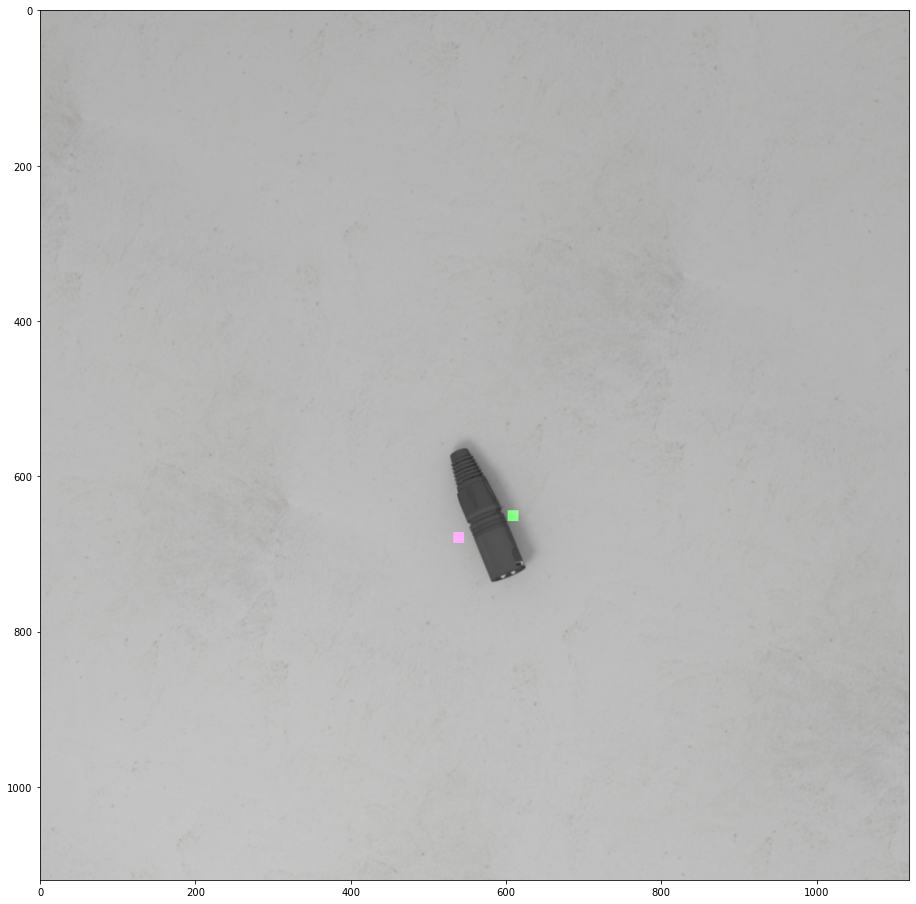

In [116]:
zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 1)
preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
origin_point[:, single_point_gt[0][0][0], single_point_gt[0][0][1]] = [0, 0, 1]
origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

plt.figure(figsize=(16,16))
show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)